# Film Recommendation Engine with TMDB 5000 Movie Dataset
*CENG 499*

Name:Buse
Surname: Biçer
Number :201611658

In this project we will try to do a  film recommendation engine with TMDB movie dataset 
The project parts is 1. Exploration 2.Clean Data 3. Recommendation Engine.

- The main Working prensible is take by the movie genres as a movie type and search all genres inclueded the genres of each movies and where to find give recommendation to he/she.


In [ ]:
#First, I define a few functions to create an interface with the new structure of the dataset.
#The code below is entirely taken from Sohier's kernel: https://www.kaggle.com/sohier/film-recommendation-engine-converted-to-use-tmdb
#Data:https://www.kaggle.com/erikbruin/movie-recommendation-systems-based-on-tmdb/data

In [1]:
import json
import pandas as pd
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
#plt.rcParams["patch.force_edgecolor"] = True
#plt.style.use('fivethirtyeight')
#mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
credits = load_tmdb_credits("C:/Users/Buse/Downloads/tmdb_5000_credits.csv")
movies = load_tmdb_movies("C:/Users/Buse/Downloads/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

C:\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [3]:
credits.head(5) # Credits dataset for the movies credits note

,movie_id,title,cast,crew
0,19995,Avatar,"[{'id': 65731, 'name': 'Sam Worthington', 'ord...","[{'department': 'Editing', 'id': 1721, 'name':..."
1,285,Pirates of the Caribbean: At World's End,"[{'id': 85, 'name': 'Johnny Depp', 'order': 0,...","[{'department': 'Camera', 'id': 120, 'name': '..."
2,206647,Spectre,"[{'id': 8784, 'name': 'Daniel Craig', 'order':...","[{'department': 'Sound', 'id': 153, 'name': 'T..."
3,49026,The Dark Knight Rises,"[{'id': 3894, 'name': 'Christian Bale', 'order...","[{'department': 'Sound', 'id': 947, 'name': 'H..."
4,49529,John Carter,"[{'id': 60900, 'name': 'Taylor Kitsch', 'order...","[{'department': 'Writing', 'id': 7, 'name': 'A..."


In [4]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'id': 289, 'name': 'Ingenious Film Partners'...","[{'name': 'United States of America', 'iso_316...",2009-12-10,2787965087,162.0,"[{'name': 'English', 'iso_639_1': 'en'}, {'nam...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'id': 2, 'name': 'Walt Disney Pictures'}, {'...","[{'name': 'United States of America', 'iso_316...",2007-05-19,961000000,169.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...","[{'name': 'United Kingdom', 'iso_3166_1': 'GB'...",2015-10-26,880674609,148.0,"[{'name': 'Français', 'iso_639_1': 'fr'}, {'na...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'id': 923, 'name': 'Legendary Pictures'}, {'...","[{'name': 'United States of America', 'iso_316...",2012-07-16,1084939099,165.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'id': 2, 'name': 'Walt Disney Pictures'}]","[{'name': 'United States of America', 'iso_316...",2012-03-07,284139100,132.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [6]:
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
#To develop the recommendation engine firstly I describe a keywords for the movies. I mean for the each movies
#described some keywords about the movie genres. Which means is that provide the movies kind of content.


In [8]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
set_keywords.remove('')

In [9]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [10]:
# To drow a graph for the genres types for the frequency I list the decresing order to eliminate the not clean data.When I 
# use this function it will be explore the content of the genres column

In [11]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

In [12]:
#Thw Wordcloud library make by the keywords to each movie and make list the all movie

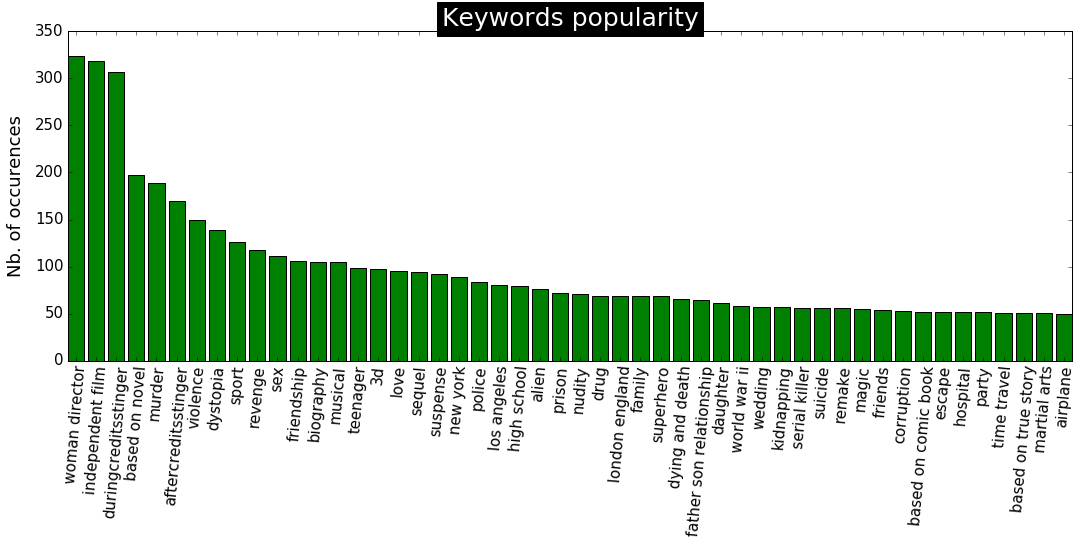

In [13]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
# WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words

#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

#### Clearing the missing values into the the dataset

In [15]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] 
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


### Number of movie per year

In [16]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

### Let me drow a graph
###### This graphic was drawn using the seaborn library

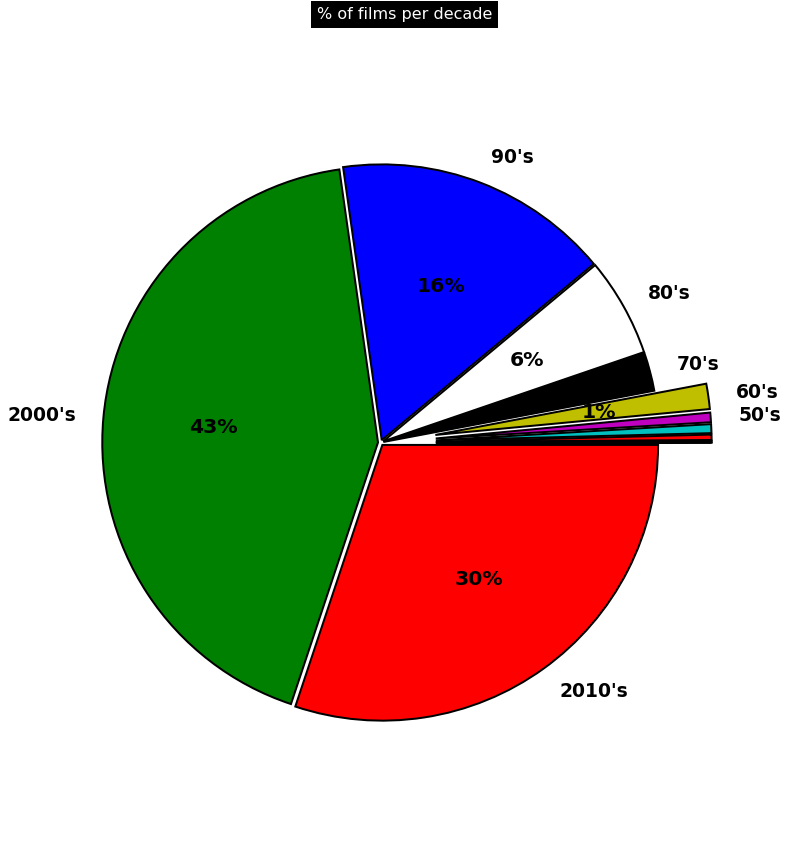

In [17]:
sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font',weight='bold')
f, ax = plt.subplots(figsize=(11, 15))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

### The Genres of movies
The genres type is important for the movies. Because the genres include the movie's popularity. Which means is an example; the movie has a lot of genres this is include each types of genres popularit and it has been the nearly all movie recommendation 

In [18]:
# Let me splt the genres by using the '|' operator
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [19]:
#As ana example of genres frequency counter and It is shown thetop five frequent genres using in TMDB movies in below 
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

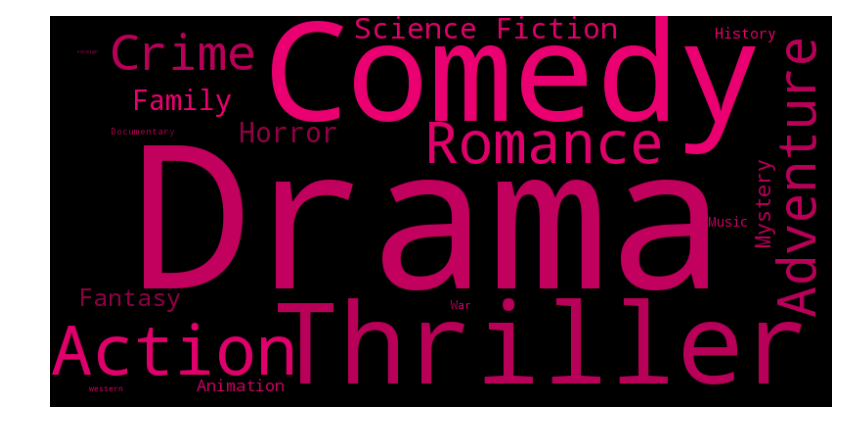

In [20]:
# In this graph I used to show a other algorithm types usage of in the cloud graph. When I draw a this graph I used the 
#bilinear interpolation method for the frequeny of the words in the keyword occurences 
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 1000 # define the color of the words
f, ax = plt.subplots(figsize=(14, 10))
wordcloud = WordCloud(width=800,height=400, background_color='black', 
                      max_words=500,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Recommendation Engine
Let me explain the recommendation engine working principle;
####  How can I estimate the movies similarity
The movies similarity working principle is based on the movies genres which means the genres important for the all movies 
When people seacrh a movie , they consider the movies genres.So when I develop a recommeantaion engine it was based on the genres.


In [21]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

## 3.2 Definition of the engine functions
####  Collect the director name , actor name and plot_keywords
This function return the these variables taken by the given movie id's info

In [22]:
def entry_variables(df, id_entry): 
    col_labels = []    
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)
            
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
                
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

#### The add variable function is using to add a new recommended movie by the recommendation movie dataset

In [23]:
def add_variables(df, REF_VAR):    
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]): continue
            for s in row[categorie].split('|'):
                if s in REF_VAR: df.set_value(index, s, 1)            
    return df

### Recommand Method
The recommand method do the recommandation to user by using the Nearest Neighbor algorthm and this algortihm metric is a euclidian.The recommand function call the other declared function to determine the recommendation list.

In [24]:
def recommand(df, id_entry):    
    df_copy = df.copy(deep = True)    
    liste_genres = set()
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))    
    #_____________________________________________________
    # Create additional variables to check the similarity
    variables = entry_variables(df_copy, id_entry)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)
    #____________________________________________________________________________________
    # determination of the closest neighbors: the distance is calculated / new variables
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=35, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_entry].as_matrix(variables)
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)

    return indices[0][:]
    

In [25]:
# This function excract and taka the some parameter about the movies in the dataset

In [26]:
def extract_parameters(df, liste_films):     
    parametres_films = ['_' for _ in range(35)]
    i = 0
    max_users = -1
    for index in liste_films:
        parametres_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'imdb_score', 'num_user_for_reviews', 
                                        'num_voted_users']])
        parametres_films[i].append(index)
        max_users = max(max_users, parametres_films[i][4] )
        i += 1
        
    title_main = parametres_films[0][0]
    annee_ref  = parametres_films[0][1]
    parametres_films.sort(key = lambda x:critere_selection(title_main, max_users,
                                    annee_ref, x[0], x[1], x[2], x[4]), reverse = True)

    return parametres_films 

In [27]:
# The sequel function compares the 2 titles passed in input and defines if these titles are similar or not by using the
#fuzzywuzzy library

In [28]:
def sequel(titre_1, titre_2):    
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

In [29]:
def critere_selection(title_main, max_users, annee_ref, titre, annee, imdb_score, votes):    
    if pd.notnull(annee_ref):
        facteur_1 = gaussian_filter(annee_ref, annee, 20)
    else:
        facteur_1 = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        facteur_2 = gaussian_filter(votes, max_users, sigma)
    else:
        facteur_2 = 0
        
    if sequel(title_main, titre):
        note = 0
    else:
        note = imdb_score**2 * facteur_1 * facteur_2
    
    return note

In [30]:
# The add to selection method add a new movie name by searchin the smilarities and founded the similar movies.

In [31]:
def add_to_selection(film_selection, parametres_films):    
    film_list = film_selection[:]
    icount = len(film_list)    
    for i in range(31):
        already_in_list = False
        for s in film_selection:
            if s[0] == parametres_films[i][0]: already_in_list = True
            if sequel(parametres_films[i][0], s[0]): already_in_list = True            
        if already_in_list: continue
        icount += 1
        if icount <= 5:
            film_list.append(parametres_films[i])
    return film_list

In [32]:
#The remove sequels function remove sequels from the list if more that two films from a serie are present.
#The older one is kept.

In [33]:
def remove_sequels(film_selection):    
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if sequel(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list  

## Main Method
This method create a list of 5 movies that will be recommended to the user.

In [34]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False):    
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    liste_films = recommand(df, id_entry)
    #__________________________________
    # Create a list of 35 films
    parametres_films = extract_parameters(df, liste_films)
    #_______________________________________
    # Select 5 films from this list
    film_selection = []
    film_selection = add_to_selection(film_selection, parametres_films)
    #__________________________________
    # delation of the sequels
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # add new films to complete the list
    film_selection = add_to_selection(film_selection, parametres_films)
    #_____________________________________________
    selection_titres = []
    for i,s in enumerate(film_selection):
        selection_titres.append([s[0].replace(u'\xa0', u''), s[5]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titres

In [35]:
dum = find_similarities(df_initial, 12, del_sequels = False, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Pirates of the Caribbean: Dead Man's Chest
nº2      -> Pirates of the Caribbean: At World's End
nº3      -> Pirates of the Caribbean: The Curse of the Black Pearl
nº4      -> Pirates of the Caribbean: On Stranger Tides
nº5      -> Cutthroat Island              
